# Preparation steps

Download the data:
```bash
ssh myusername@weber...
```
or locally
```bash
mkdir leture04
cd lecture04
cp /tmp/mhd_fields.h5 .
```
Then, download this Jupyter notebook from here:
[https://www.app.physik.uni-potsdam.de/~jbenacek/ASPS/lecture04-handson.ipynb](https://www.app.physik.uni-potsdam.de/~jbenacek/ASPS/lecture04-handson.ipynb)

### Selection of matplotlib inline vs. notebook

In [1]:
%matplotlib inline
#%matplotlib notebook
#from ipywidgets import *

### Import all necessary packages

In [2]:
from __future__ import print_function
import sys
import os
import h5py

import numpy as np
import math
#from math import sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import scipy.constants as constant
import psutil
import random

## Plotting functions used throughout the notebook

In [3]:
!mkdir figures

mkdir: adresář „figures“ nelze vytvořit: Soubor již existuje


In [4]:
def contour_plot(field2d, fieldname, colorbar_label,
                 xgrid, ygrid, xppc=None, yppc=None,
                 xmin=None, xmax=None, ymin=None, ymax=None):
    field2d = field2d[:,:]
    fileplot = fieldname+'.png'
    fig1 = plt.figure()
    #print('plotting :',fileplot )

    minfield = np.min(field2d)
    maxfield = np.max(field2d)
    #This makes the colortable symmetric around 0
    if np.abs(maxfield) >= np.abs(minfield):
        maxfield = - minfield
    else:
        minfield = - maxfield

    plt.imshow(np.transpose(field2d),aspect='auto',interpolation='spline36', cmap=mpl.cm.seismic,
               origin='lower', extent=[xgrid[0], xgrid[-1], ygrid[0], ygrid[-1]],
               vmin=minfield,vmax=maxfield)

    cbar=plt.colorbar()
    cbar.solids.set_rasterized(True)
    cbar.formatter.set_useOffset(False)
    plt.xlabel(r'x')
    plt.ylabel(r'y')
    plt.title(colorbar_label)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.tight_layout()

    #plot particle trajectories
    if xppc is not None and yppc is not None:
        plot_every_points=10**3
        #plt.scatter( [xppc.ravel()][::plot_every_points], (yppc.ravel())[::plot_every_points], color='green', s=0.1)
        print('len(xppc.ravel()) ', len(xppc.ravel()))
        xppc_array = np.array(xppc.ravel())
        print('xppc_array.shape ', xppc_array.shape)
        plt.scatter( xppc.ravel(), yppc.ravel(), color='green', s=0.1)
        #initial point
        xppc1 = (xppc.ravel())[0]
        yppc1 = (yppc.ravel())[0]
        xppcl = (xppc.ravel())[-1]
        yppcl = (yppc.ravel())[-1]
        plt.plot(xppc1, yppc1, marker='o', markersize=7, color='green')
        plt.annotate(str(round(t_axis[0],3)), xy = (xppc1+0.05, yppc1+0.05),
                     xycoords='data',color="green", fontsize=8)
        plt.plot(xppcl, yppcl, marker='o', markersize=7, color='green')
        plt.annotate(str(round(t_axis[-1],3)), xy = (xppcl+0.05, yppcl+0.05),
                     xycoords='data',color="green", fontsize=8)

    plt.savefig("figures/"+fileplot)
    #plt.close(fig1)
    plt.show()

In [46]:
def line_plot(plotname, yvec, xvec, ylabel, xlabel,
              linestyle1=None, yvec2=None, xvec2=None,
              ylabel2=None, linestyle2=None,
              ylabel_combined=None):
    fileplot = plotname+'.'+'pdf'
    #print('plotting :',fileplot )
    fig1 = plt.figure()

    plt.plot( xvec, yvec, label=ylabel, alpha=0.7, linewidth=3.0, color='black', linestyle=linestyle1)
    plt.plot( xvec2, yvec2, label=ylabel2, alpha=0.7, linewidth=3.0, color='red', linestyle=linestyle1)

    leg=plt.legend()
    leg.get_frame().set_alpha(0.5)
    plt.tight_layout()

    plt.savefig("figures/"+fileplot)
    #plt.close(fig1)
    plt.show()

### Reading the electric and magnetic fields from the file

In [7]:
filename = 'mhd_fields.h5'
h5file = h5py.File(filename,"r")
bx_at_grid = np.array(h5file.get("/fields/magnetic/Bx"))[:,:]
by_at_grid = np.array(h5file.get("/fields/magnetic/By"))[:,:]
bz_at_grid = np.array(h5file.get("/fields/magnetic/Bz"))[:,:]
ux_at_grid = np.array(h5file.get("/fields/velocity/Ux"))[:,:]
uy_at_grid = np.array(h5file.get("/fields/velocity/Uy"))[:,:]
uz_at_grid = np.array(h5file.get("/fields/velocity/Uz"))[:,:]
h5file.close()

## Part 1: MHD simulation parameters

In [13]:
#Grid creation
nx   = 12802 #total number of grid points along y (original simulation)
ny   = 3202  #total number of grid points along y (original simulation)
miny = 600   #minimum grid point along y (in h5 file)
maxy = 1000  #maximum grid point along y (in h5 file)
dx   = 0.025 #In units of l0
ny_effective = maxy - miny + 1
xgrid = np.arange(nx) * dx
ygrid = np.arange(ny_effective-1) * dx
print('xgrid', xgrid)
print('ygrid', ygrid)

xgrid [0.00000e+00 2.50000e-02 5.00000e-02 ... 3.19975e+02 3.20000e+02
 3.20025e+02]
ygrid [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.    1.025 1.05  1.075 1.1   1.125 1.15  1.175
 1.2   1.225 1.25  1.275 1.3   1.325 1.35  1.375 1.4   1.425 1.45  1.475
 1.5   1.525 1.55  1.575 1.6   1.625 1.65  1.675 1.7   1.725 1.75  1.775
 1.8   1.825 1.85  1.875 1.9   1.925 1.95  1.975 2.    2.025 2.05  2.075
 2.1   2.125 2.15  2.175 2.2   2.225 2.25  2.275 2.3   2.325 2.35  2.375
 2.4   2.425 2.45  2.475 2.5   2.525 2.55  2.575 2.6   2.625 2.65  2.675
 2.7   2.725 2.75  2.775 2.8   2.825 2.85  2.875 2.9   2.925 2.95  2.975
 3.    3.025 3.05  3.075 3.1   3.125 3.15  3.175 3.2   3.225 3.25  3.275
 3.3   3.325 3.35  3.375 3.4   3.425 3.45  3.475 3.5   3.525 3.55  3.575
 3.6   3.625 3.65  3.675 3.7   3.

In [9]:
# Degree of spline interpolation
interpolation_degree = 1

# Physical parameters
beta_p = 0.5 # Plasma beta
eta = 0.001  # Resistivity

# Physical constants
mu0 = constant.mu_0
epsilon_0 = constant.epsilon_0
c = constant.c
qe = constant.e
me = constant.m_e
mp = constant.m_p

# Normalizations constants
l0 = 2.5*10**4
t0 = 1.
B0 = 7.5*10**(-8)
charge = qe
mass = me

#Derived normalizations:
V0 = l0 / t0
V02c = V0 / c
n0 = B0**2 / (V0**2 * mu0 * mp)
omega_pe = np.sqrt(n0 * charge**2 / (epsilon_0*me))
omega_pi = omega_pe / (mp/me)
proton_skin_depth = c / omega_pi
omega_ce = charge * B0 / mass
omega_cp = charge * B0 / mp
omega_pe2omega_ce = omega_pe / omega_ce

print('n0 ', n0)
print('proton_skin_depth ', proton_skin_depth)
print('l0/proton_skin_depth ', l0/proton_skin_depth)
print('t0*omega_cp ', t0*omega_cp)
print('omega_pe ', omega_pe)
print('omega_ce ', omega_ce)
print('Plasma frequency/cyclotron frequency', omega_pe2omega_ce)
print('V0/c ', V02c)

j0 = B0 / (mu0*l0)
eta0 = mu0 * l0 * B0
print('j0 ', j0)
print('eta0 ', eta0)

n0  4281883630.6033435
proton_skin_depth  149114.72473767557
l0/proton_skin_depth  0.16765614558844072
t0*omega_cp  7.184124866957727
omega_pe  3691551.751191799
omega_ce  13191.150080791223
Plasma frequency/cyclotron frequency 279.8506368726247
V0/c  8.339102379953801e-05
j0  2.387324145078829e-06
eta0  2.3561944914749998e-09


## Part 2: Particle mover parameters

In [14]:
# Here setup iteration time
dt = 1e-5 #timestep for iteration
t = 0.    #initial value of t
tf = 0.3 #final time of iteration
nt = int(round(tf/dt)) #total number iterations

print('Particle mover: dt: ', dt)
print('Particle iterations: nt: ', nt)
print('Particle mover: dt*omega_ce: ', dt*omega_ce)
print('Particle mover: dt*omega_pe: ', dt*omega_pe)
print('Particle mover: final t: ', tf)
print('Particle mover: final t.omega_ce: ', tf*omega_ce)
print('Particle mover: final t.omega_cp: ', tf*omega_cp)

Particle mover: dt:  1e-05
Particle iterations: nt:  30000
Particle mover: dt*omega_ce:  0.13191150080791225
Particle mover: dt*omega_pe:  36.91551751191799
Particle mover: final t:  0.3
Particle mover: final t.omega_ce:  3957.345024237367
Particle mover: final t.omega_cp:  2.155237460087318


In [15]:
#Initial conditions

number_particles = 100                 # Total number particles
f = np.zeros((6, number_particles) )   # Particle position and velocity vector

f[0,:] = np.random.uniform(70, 100, size=number_particles) # x
f[1,:] = np.repeat(5., number_particles)                   # y
f[2,:] = np.repeat(0, number_particles)                    # z
f[3,:] = np.random.uniform(-400., 400., size=number_particles) # v_x
f[4,:] = np.random.uniform(-100., 100., size=number_particles) # v_y
f[5,:] = np.random.uniform(-100., 100., size=number_particles) # v_z

### Calculating supplementary fields

In [16]:
#Ampere's law: curl B = j
curlbx_at_grid = np.gradient(bz_at_grid,dx,dx)[1] #- np.gradient(by,dx,dx,dx)[2]
curlby_at_grid = -np.gradient(bz_at_grid,dx,dx)[0] # + np.gradient(bx,dx,dx,dx)[2]
curlbz_at_grid = np.gradient(by_at_grid,dx,dx)[0] - np.gradient(bx_at_grid,dx,dx)[1]

#Resistive MHD Ohms law: E = -VxB + eta.j
ex_at_grid = by_at_grid*uz_at_grid - bz_at_grid*uy_at_grid + eta*curlbx_at_grid
ey_at_grid = bz_at_grid*ux_at_grid - bx_at_grid*uz_at_grid + eta*curlby_at_grid
ez_at_grid = bx_at_grid*uy_at_grid - by_at_grid*ux_at_grid + eta*curlbz_at_grid

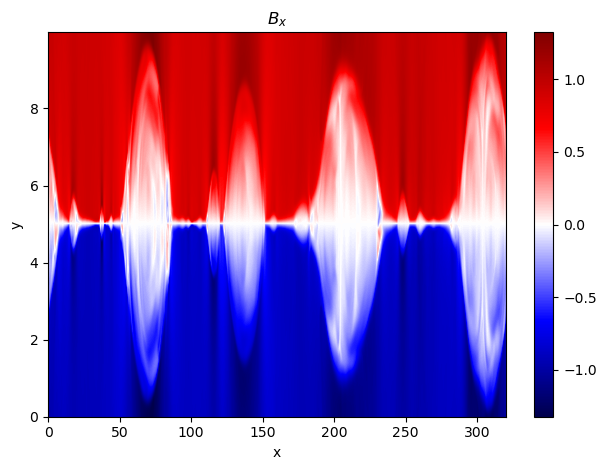

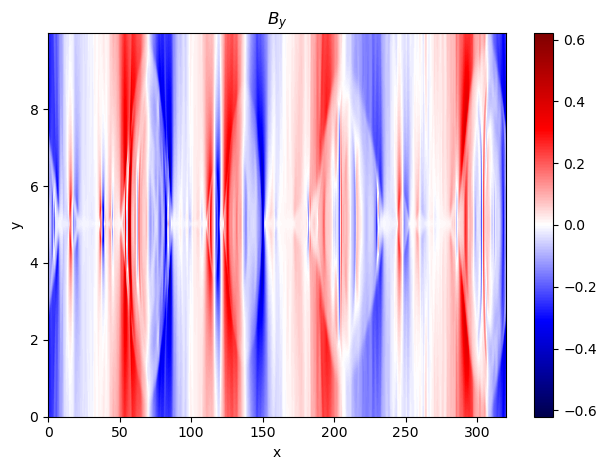

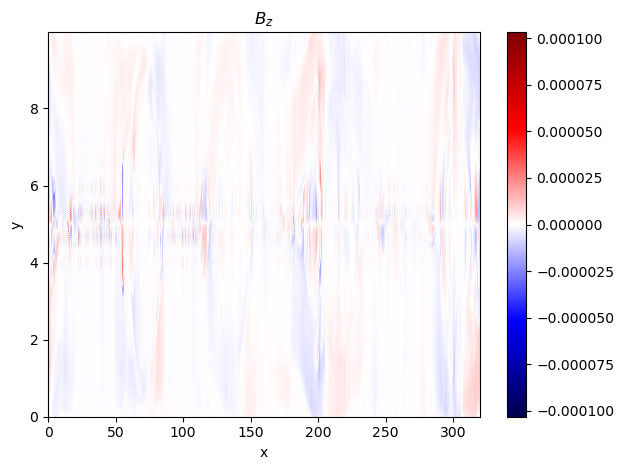

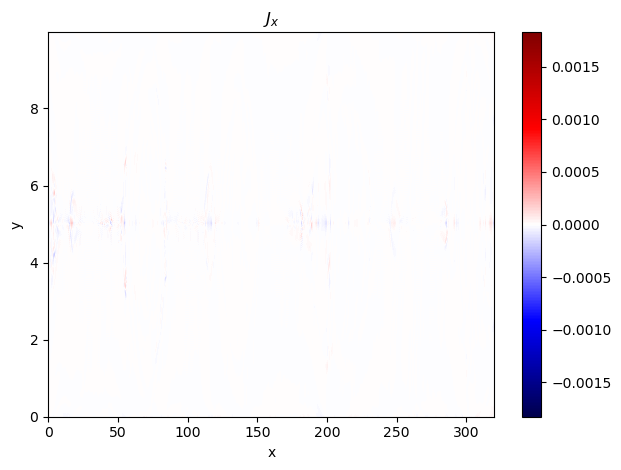

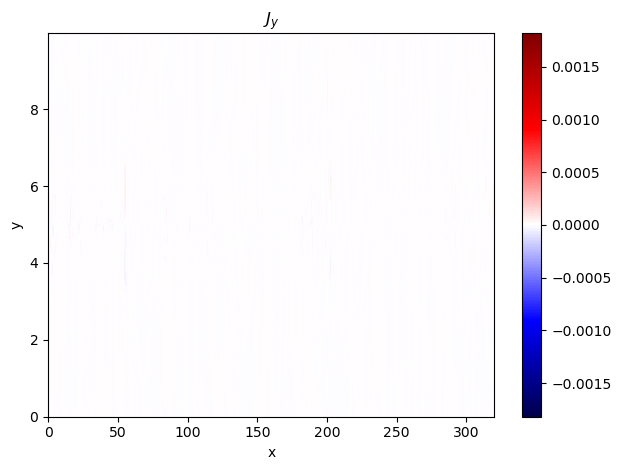

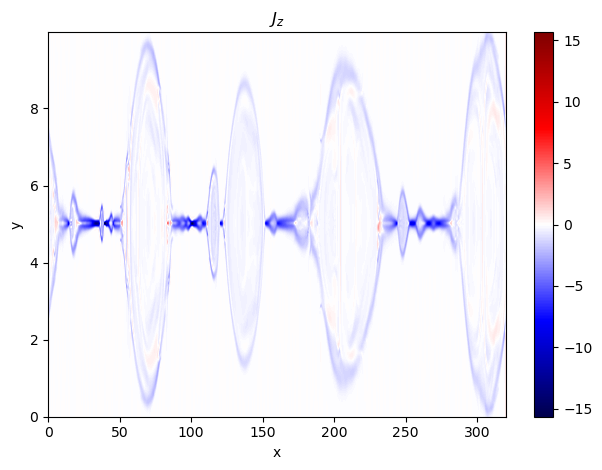

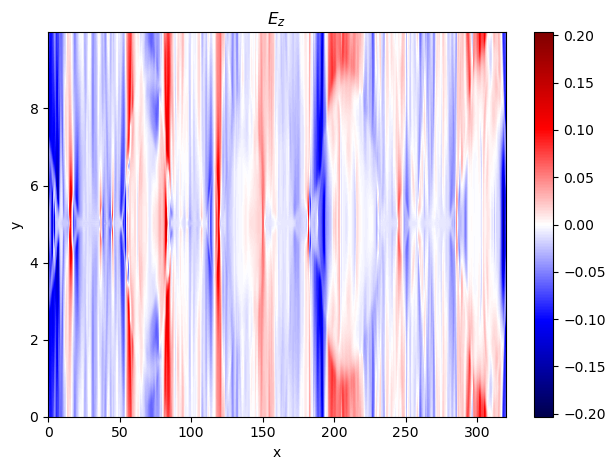

In [17]:
# Plot fields
contour_plot(bx_at_grid, 'bx', r'$B_x$', xgrid, ygrid)
contour_plot(by_at_grid, 'by', r'$B_y$', xgrid, ygrid)
contour_plot(bz_at_grid, 'bz', r'$B_z$', xgrid, ygrid)

contour_plot(curlbx_at_grid, 'jx', r'$J_x$', xgrid, ygrid)
contour_plot(curlby_at_grid, 'jy', r'$J_y$', xgrid, ygrid)
contour_plot(curlbz_at_grid, 'jz', r'$J_z$', xgrid, ygrid)
contour_plot(ez_at_grid, 'ez', r'$E_z$', xgrid, ygrid)

### Debug for memory usage

In [18]:
print('12*(bx_at_grid).nbytes [Gb] = ', 12*bx_at_grid.nbytes/(1024.*1024.*1024.))

print('memory from psutil',  psutil.Process().memory_info().rss / (1024 * 1024*1024.), "GB")
#del curlbx, curlby, curlbz
#return, bx, by, bz, ex, ey, ez

12*(bx_at_grid).nbytes [Gb] =  0.22891759872436523
memory from psutil 0.4607200622558594 GB


### Interpolation of electric and magnetic fields to particle position

In [19]:
def fields_at_position(x,y):
    #Splines calculated elsewhere

    #Evaluate fields at particle's position using the splines coefficients
    bx_at_position = bx_spline.ev(x, y)
    by_at_position = by_spline.ev(x, y)
    bz_at_position = bz_spline.ev(x, y)

    #Get splines coefficients of EB fields
    ex_at_position = ex_spline.ev(x, y)
    ey_at_position = ey_spline.ev(x, y)
    ez_at_position = ez_spline.ev(x, y)
    #del ex_spline, ey_spline, ez_spline

    #Auxiliary fields for guiding center approximation
    #btotal2 = bx*bx + by*by + bz*bz
    #ecrossb_x = (ey*bz - ez*by)/btotal2
    #ecrossb_y = (ez*bx - ex*bz)/btotal2
    #ecrossb_z = (ex*by - ey*bx)/btotal2

    #abbx
    #bxbx
    #uexx
    #epara=(pex*pbx+pey*pby+pez*pbz)/pabb;

    return ex_at_position, ey_at_position, ez_at_position,\
           bx_at_position, by_at_position, bz_at_position

### Particle push

In [20]:
def dfdt(f,t):
    df=np.zeros((6,number_particles))

    #many particles
    #particle's coordinates
    x = f[0,:]
    y = f[1,:]
    #z = f[2] #always zero for 2D
    #particle velocity components
    vx = f[3,:]
    vy = f[4,:]
    vz = f[5,:]

    #Get EB fields at particle's position
    ex, ey, ez, bx, by, bz = fields_at_position(x,y)

    #For many particles
    df[0,:] = vx
    df[1,:] = vy
    df[2,:] = vz
    df[3,:] = omega_ce*(ex + vy*bz - vz*by)
    df[4,:] = omega_ce*(ey + vz*bx - vx*bz)
    df[5,:] = omega_ce*(ez + vx*by - vy*bx)

    return df

    #Guiding center approximation
    #df[0]=dux+x[3]*pbx/pabb/gamma0;
    #df[1]=duy+x[3]*pby/pabb/gamma0;
    #df[2]=duz+x[3]*pbz/pabb/gamma0;
    ##//**************** Parallel Velocity
    #df[3]=1.0/cc2*epara
        #-adia/gamma0*(pbx/pabb*pabbx+pby/pabb*pabby)
        #+x[3]*(puex*(pbx/pabb*pbxbx+pby/pabb*pbxby)+puey*(pbx/pabb*pbybx+pby/pabb*pbyby)+puez*(pbx/pabb*pbzbx+pby/pabb*pbzby))
        #+gamma0*(puex*(puex*pbxbx+puey*pbxby)+puey*(puex*pbybx+puey*pbyby)+puez*(puex*pbzbx+puey*pbzby))
        #+gamma0*(puex*pbxbt+puey*pbybt+puez*pbzbt);

### Calculating splines

In [21]:
#Get splines coefficients of B fields
bx_spline = interpolate.RectBivariateSpline(xgrid, ygrid, bx_at_grid, kx=interpolation_degree, ky=interpolation_degree)
by_spline = interpolate.RectBivariateSpline(xgrid, ygrid, by_at_grid, kx=interpolation_degree, ky=interpolation_degree)
bz_spline = interpolate.RectBivariateSpline(xgrid, ygrid, bz_at_grid, kx=interpolation_degree, ky=interpolation_degree)

#Get splines coefficients of B fields
ex_spline = interpolate.RectBivariateSpline(xgrid, ygrid, ex_at_grid, kx=interpolation_degree, ky=interpolation_degree)
ey_spline = interpolate.RectBivariateSpline(xgrid, ygrid, ey_at_grid, kx=interpolation_degree, ky=interpolation_degree)
ez_spline = interpolate.RectBivariateSpline(xgrid, ygrid, ez_at_grid, kx=interpolation_degree, ky=interpolation_degree)

print('memory from psutil',  psutil.Process().memory_info().rss / (1024 * 1024*1024.), "GB")

memory from psutil 0.6898994445800781 GB


In [22]:
t_axis = np.array([])

x_vec  = np.zeros((nt,number_particles) )
y_vec  = np.zeros((nt,number_particles) )
z_vec  = np.zeros((nt,number_particles) )
vx_vec = np.zeros((nt,number_particles) )
vy_vec = np.zeros((nt,number_particles) )
vz_vec = np.zeros((nt,number_particles) )

### Moving particles by Runge-Kutta 4 (fourth-order)

In [23]:
counter_iter = 0
while (t <= tf ):
        if ((counter_iter % round(nt/10.))  ==  0):
            print('particle mover: iterating %',100.*counter_iter/float(nt))
            print('memory from psutil',  psutil.Process().memory_info().rss / (1024 * 1024*1024.), "GB")

        #print('counter_iter: ', counter_iter)
        t_axis = np.append(t_axis, t)

        x_vec[counter_iter,:] = f[0,:]
        y_vec[counter_iter,:] = f[1,:]
        z_vec[counter_iter,:] = f[2,:]
        vx_vec[counter_iter,:] = f[3,:]
        vy_vec[counter_iter,:] = f[4,:]
        vz_vec[counter_iter,:] = f[5,:]

        #def rk4(x):
        k1 = dt * dfdt(f,t)
        k2 = dt * dfdt(f+k1/2, t+dt/2)
        k3 = dt * dfdt(f+k2/2, t+dt/2)
        k4 = dt * dfdt(f+k3, t+dt)
        f += (k1 + 2*k2 + 2*k3 + k4)/6.
        t += dt
        counter_iter += 1


print('total iterations ', counter_iter)
#print('t_axis', t_axis)

particle mover: iterating % 0.0
memory from psutil 0.6900215148925781 GB
particle mover: iterating % 10.0
memory from psutil 0.7033271789550781 GB
particle mover: iterating % 20.0
memory from psutil 0.7167549133300781 GB
particle mover: iterating % 30.0
memory from psutil 0.7301826477050781 GB
particle mover: iterating % 40.0
memory from psutil 0.7436103820800781 GB
particle mover: iterating % 50.0
memory from psutil 0.7570381164550781 GB
particle mover: iterating % 60.0
memory from psutil 0.7705879211425781 GB
particle mover: iterating % 70.0
memory from psutil 0.7838935852050781 GB
particle mover: iterating % 80.0
memory from psutil 0.7973213195800781 GB
particle mover: iterating % 90.0
memory from psutil 0.8107490539550781 GB
total iterations  30000


### Plot a particle motion for given particle_id

len(xppc.ravel())  30000
xppc_array.shape  (30000,)


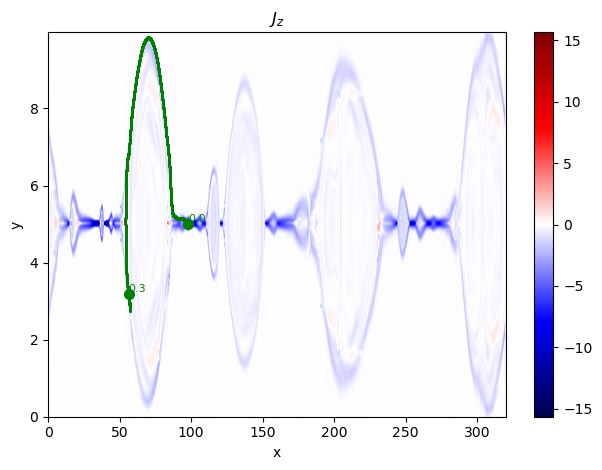

In [27]:
particle_id = 0
#print('particle_id ', particle_id)
#print('x_vec[:,particle_id]', x_vec[:,particle_id])
#print('y_vec[:,particle_id]', y_vec[:,particle_id])
contour_plot(curlbz_at_grid, 'jz_1', r'$J_z$', xgrid, ygrid, xppc=x_vec[:,particle_id], yppc=y_vec[:,particle_id])

len(xppc.ravel())  30000
xppc_array.shape  (30000,)


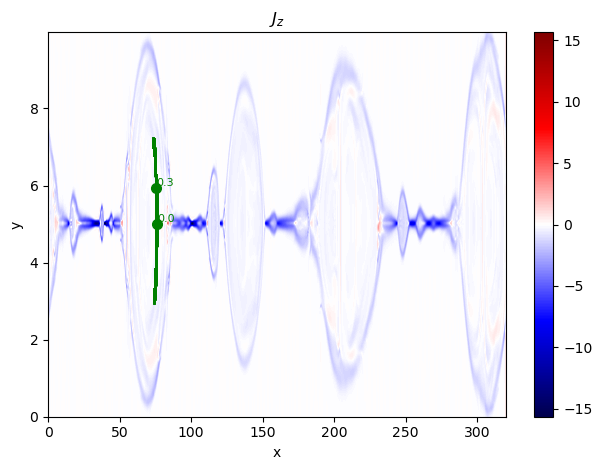

In [28]:
particle_id = 1
#print('particle_id ', particle_id)
#print('x_vec[:,particle_id]', x_vec[:,particle_id])
#print('y_vec[:,particle_id]', y_vec[:,particle_id])
contour_plot(curlbz_at_grid, 'jz_2', r'$J_z$', xgrid, ygrid, xppc=x_vec[:,particle_id], yppc=y_vec[:,particle_id] )

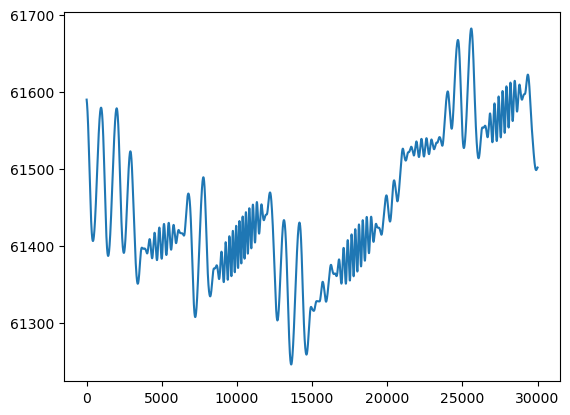

In [43]:
# Energy evolution for 
particle_id = 1
plt.plot(total_energy[:,particle_id])

In [44]:
total_energy.shape

(30000, 100)

In [45]:
total_energy[0,:].sum(),total_energy[-1,:].sum(),

(2975499.9676024937, 2984782.972829352)

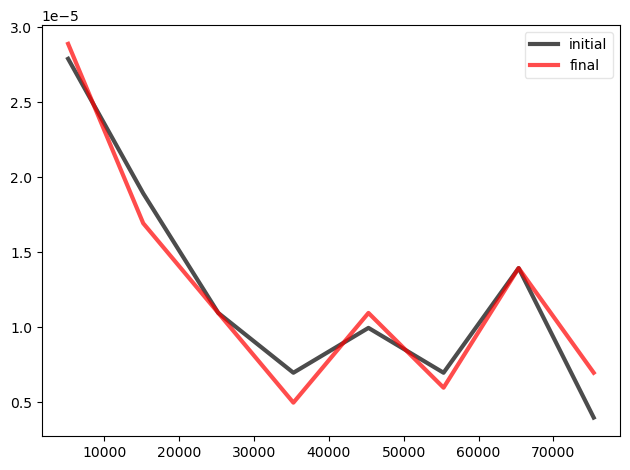

In [48]:
#Spectra
total_energy = 0.5*(vx_vec*vx_vec + vy_vec*vy_vec + vz_vec*vz_vec)

(n_init, bins) = np.histogram(total_energy[0,:], bins=8)
vec_xbins = .5*(bins[1:]+bins[:-1])
dx_bin = bins[1] - bins[0]
(n_final, bins) = np.histogram(total_energy[-1,:], bins=8)

initial_spectra = n_init/(number_particles*dx_bin)
final_spectra = n_final/(number_particles*dx_bin)

#print('initial_spectra ', initial_spectra)
#print('final_spectra ', final_spectra)

line_plot('energy_spectra', initial_spectra, vec_xbins, 'initial',  r'speed2',  linestyle1='-',  yvec2=final_spectra, xvec2=vec_xbins, ylabel2='final', linestyle2='--', ylabel_combined='')
             #,xmin=-2.5, xmax=2.5, ymin=0.000001,ymax=1.0, ylog=True)

In [36]:
print('End memory from psutil',  psutil.Process().memory_info().rss / (1024 * 1024*1024.), "GB")

End memory from psutil 0.8181419372558594 GB
